# Machine Learning Engineer Nanodegree
## Capstone Project
Darius Murawski
12.09.2018

# I. Definition
## Project Overview

### Problem Domain

Hard drives are used to save data from the operating system and different applications that are running on the server. The average price for a gigabyte is dropping and the demand for more space on the servers is growing. This results in a higher total number of hard drives running. As more drives are present in a data storage system, as more hard drives can fail, leading to data inconsistency and a major fail of the provided services. Since several years, hard drive vendors provide some values of this hard drives that reflect their current state. Based on this values, a broken drive can be identified. For more information on this so called S.M.A.R.T. values, see [wikipedia](https://en.wikipedia.org/wiki/S.M.A.R.T.). 

### Input Data overview

A crash of a hard drive in a private environment is happening very rarely because the amount of total dives is very low. I searched and found a huge dataset provied by [backblaze.com](https://www.backblaze.com/b2/hard-drive-test-data.html). They are running a huge data storage system with several thousend hard drive for their customers. For each quarter, the show their running and failed drives in a csv format for further research. They have a licence for this data, that I like to cite at this place: 

`You can download and use this data for free for your own purpose, all we ask is three things 1) you cite Backblaze as the source if you use the data, 2) you accept that you are solely responsible for how you use the data, and 3) you do not sell this data to anyone, it is free.`







## Problem Statement
Fails on a hard drive can be recovered using different techniques like raid settings or mirroring the data in different data centers. But the broken hard drive have to be replaced sooner or later with a new one, to make sure more fails on associated hard drives don’t break the data consistency. For each broken hard drive, somebody have to drive to the storage system, look it up in the storage system and replace it. This procedure have to be done each time one drive fails in the worst case and each time generating maintenance costs for the operating company. 

This costs can be reduced by replacing more drives than just the broken one by the maintenance people, as they only have to went to the storage system once and not several times. But what drives should they replace? In this Capstone project I want to generate a fail probability for each of the drives running in the storage system. The drives with a predicted fail should be replaced beforehand to reduce the maintenance costs in mid-range for the company operating the storage system.

The described problem can be seen as a binary classification problem, where the allowed labels are only 0, for “hard drive is running” and 1 for “hard drive failed”. When generating predictions, 0 represents “hard drive will run further” and 1 for “hard drive will (soon) fail and should be replaced. 

### Related papers and articles
Looking up in papers and articles, this kind of problem is referenced as predictive maintenance (PdM): Before waiting that something breaks, we replace the appropriate part in a regular maintenance to make sure that the entire system is able to continue running as expected.

|Authors|Topic / Title|Document|
|--|--|--|
|Julia Scavicchio|Definition “Predictive Maintenance” (PdM)”|[Link](https://www.hippocmms.com/blog/3-cmms-trends-for-2016-millennials-mobility-and-machine-learning)
|Jennifer Ho|Overview of industries, <br>using Algorithms to reduce their machine downtime with further links|[Link](https://www.distrelec.de/current/en/artificial-intelligence/eliminating-machine-downtime-how-ai-is-transforming-maintenance/)
|Taylor Short|What type of sensors can be used for predictive maintenance|[Link](https://www.softwareadvice.com/resources/predictive-maintenance-reduce-downtime/)
|Gian Antonio Susto,<br> Andrea Schirru,<br> Simone Pampuri,<br> Seán McLoone,<br> Alessandro Beghi|Machine Learning for Predictive Maintenance: <br>A Multiple Classifier Approach|[Link](https://ieeexplore.ieee.org/abstract/document/6879441)
|Dr. Miguel A. Sanz Bobi,<br> Maria Cruz García,<br> Javier del Pico-Aznar | SIMAP: Intelligent System for Predictive Maintenance: <br>Application to the health condition monitoring of a windturbine gearbox|[Link](https://www.sciencedirect.com/science/article/pii/S0166361506000534)
|Hongfei Li,<br> Dhaivat Parikh,<br> Qing He,<br> Buyue Qian,<br> Zhiguo Li Dongping Fang,<br> Arun Hampapur| Improving rail network velocity: <br>A machine learning approach to predictive maintenance | [Link](https://www.acsu.buffalo.edu/~qinghe/papers/journal/2014%20Railway%20Velocity.pdf)
|Eduardo Pinheiro,<br> Wolf-Dietrich Weber,<br> Luiz Andre Barroso - Google| Failure Trends in a Large Disk Drive Population| [Link](http://static.googleusercontent.com/media/research.google.com/en/us/archive/disk_failures.pdf) or [Link](https://ai.google/research/pubs/pub32774)
|Various|General Introduction into S.M.A.R.T.|[Link](https://en.wikipedia.org/wiki/S.M.A.R.T.)


## Solution Statement

I want to train a model that returns a "1", given by the provided features, that returns a prediction for a hard drive to fail. Drives with this value should be replaced by the maintenance team before.

## Metrics
The data is highly unbalanced. That results in using the F Beta Score to measure the performance of the model. I will not use the accuracy as metric as the data is very unbalanced. See [accuracy paradox](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/).

# II. Analysis

## Data Exploration
For each day and each drive an entry is generated in a quarter file that is than later on compressed and made available to the public. Failed drives are also included in this dataset and on the next day removed from the list. The dataset contains of the following columns (see: [backblaze.com](https://www.backblaze.com/b2/hard-drive-test-data.html)):

* Date – The date of the file in yyyy-mm-dd format.
* Serial Number – The manufacturer-assigned serial number of the drive.
* Model – The manufacturer-assigned model number of the drive.
* Capacity – The drive capacity in bytes.
* Failure – Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.
* Normalized and Raw S.M.A.R.T. values from 1 upto 255. The data have a different set of S.M.A.R.T. values.

The normalized values are sometimes not provided, for examle to return the amount of hours a drive was already running a normalization makes no sence. I decided to only use the raw values. The Ranges of the values are vendor specific. Thats why I decided not to build a model for everything, but instead generate a model specific one.

The entire dataset (I call it `raw`) is split into several pieces. Each piece referencing the year and the quarter that this data was extracted from. The following table shows some more detailed information about the dataset:

|file|year|quarter(s)|compressed MB|uncompressed MB|files|
|--  |  --|       --|           --|             --|   --|
|[data_2013.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_2013.zip)|2013|Q1,Q2,Q3,Q4|77|738|266|
|[data_2014.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_2014.zip)|2014|Q1,Q2,Q3,Q4|560|2880|365|
|[data_2015.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_2015.zip)|2015|Q1,Q2,Q3,Q4|803|4294|366|
|[data_Q1_2016.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2016.zip)|2016|Q1|257|1356|92|
|[data_Q2_2016.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2016.zip)|2016|Q2|278|1478|92|
|[data_Q3_2016.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2016.zip)|2016|Q3|307|1604|92|
|[data_Q4_2016.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2016.zip)|2016|Q4|321|1651|92|
|[data_Q1_2017.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2017.zip)|2017|Q1|323|1659|90|
|[data_Q2_2017.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2017.zip)|2017|Q2|368|1895|91|
|[data_Q3_2017.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2017.zip)|2017|Q3|406|2027|92|
|[data_Q4_2017.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2017.zip)|2017|Q4|434|2112|93|
|[data_Q1_2018.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2018.zip)|2018|Q1|484|2381|90|
|[data_Q1_2018.zip](https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2018.zip)|2018|Q2|502|2472|91|
|Total|2013 - 2018|14|5128|26536|1912|

For the first years, the data was collected on a year basis, but then starting from 2016, the data was splitted by quarter.

The Input Features are the hard drive model, and the returned S.M.A.R.T. values of the drive at the timestamp represented by "date". The data is highly unbalanced, as only about 1.8% drives in the reporting period between April 2003 and June 2018 failed (see: [backblaze.com](https://www.backblaze.com/blog/hard-drive-stats-for-q2-2018/)) .

As of time writing, Q2 for 2018 was the latest dataset. Note that the amount of information changed over time. From 2013 to 2014, 80 columns of data were collected for each drive. From 2015 to 2017 90 columns of data were collected. For Q2 2018, 104 columns with data was collected. Each reflecting a subset of the possible 256 S.M.A.R.T. "columns" with the raw and the normalized value. 

I choosed as an example the hard drive model "ST6000DX000" by Seagate for the visualization part. Examples are provided in "Exploratory Visualisation":

## Exploratory Visualization

The mapping and the preferred value-range of each S.M.A.R.T. value was extracted from [wikipedia.org](https://en.wikipedia.org/wiki/S.M.A.R.T.) - I extracted the map to the [helper.py](helper.py) to have a better overview inside the nodebook

I could extract three groups of features based on the following plots:
* Feature that seem to not be correlated to a fail of the given hard drive model
* Feature that are supposed to have a correlation, proposed by wikipedia
* Feature that seems to have a correlation, based on the plot. 

In [1]:
from helper import Helper
helper = Helper()
smart_to_name = helper.smart_to_name()

# We also need to define the basic column names, that are also present beside the S.M.A.R.T. values. 
# They are also extracted to the helper.py
column_list = helper.column_list()


from preprocessing import Preprocessing # A lot of preprocessing code was extracted, as requested by the first review
from kerasalgorithm import KerasAlgorithm
from xgboostgbtreealgorithm import XGBoostGbtreeAlgorithm
from lightgbmalgorithm import LightGBMAlgorithm
from algorithm_runner import AlgorithmRunner # Extracted the complex running logic
from winner import Winner # Extract winner logic
from searchwithgrid import SearchWithGrid # Own GridSearch Implementation
from validation import Validation # Validation class
from freestyle import Freestyle # Freestyle visualisation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import glob
import sys
import requests
import shutil
import zipfile
# see: https://docs.python.org/3/library/concurrent.futures.html
from concurrent.futures import Executor, ThreadPoolExecutor
import math
from math import floor
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

from tqdm import tqdm
from joblib import Parallel, delayed
from time import time, sleep

from traceback import print_stack

# This makes sure that my C: drives is not full of the downloaded data...
if os.path.exists(os.path.join('D:','capstone')):
    os.chdir(os.path.join('D:','capstone'))

Using TensorFlow backend.


In [2]:
if not os.path.exists(os.path.join('drives', 'ST6000DX000.csv')):
    raise Exception('Please run first the data preprocessing steps, before rerunning this cells as they depend on the preprocessing results!')

In [9]:
st_df = pd.read_csv(os.path.join('drives', 'ST6000DX000.csv'), names=column_list, header=None)

In [13]:
st_df.dropna(inplace=True, how='all', axis='columns')

In [14]:
st_df.rename(columns=smart_to_name, inplace=True)

Lets check if any unmapped columns exist, that we have to take a look at:

In [16]:
st_df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'Read Error Rate', 'Spin-Up Time', 'Start/Stop Count',
       'Reallocated Sectors Count', 'Seek Error Rate', 'Power-On Hours',
       'Spin Retry Count', 'Power Cycle Count', 'SATA Downshift Error Count',
       'End-to-End error', 'Reported Uncorrectable Errors', 'Command Timeout',
       'High Fly Writes', 'Temperature Difference', 'G-sense Error Rate',
       'Power-off Retract Count', 'Load Cycle Count', 'Temperature',
       'Hardware ECC Recovered', 'Current Pending Sector Count',
       '(Offline) Uncorrectable Sector Count', 'UltraDMA CRC Error Count',
       'Head Flying Hours', 'Total LBAs Written', 'Total LBAs Read'],
      dtype='object')

no, everything is mapped given a name. Now lets define the plotting method:

In [4]:
def plot_feature(feature, df):
    plt.boxplot(
            [np.array(df[df['failure'] == 0][feature]), np.array(df[df['failure'] == 1][feature])],            
            vert=False,
            labels=['running: {}'.format(feature),'failed: {}'.format(feature)],
            autorange=True, widths=0.9)
    plt.show()  

### Not Correlated Features

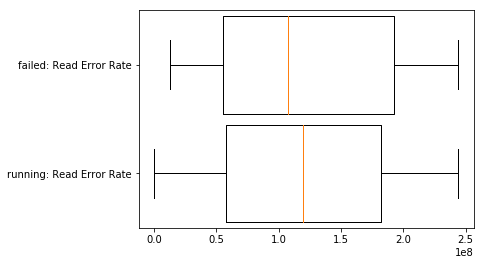

In [18]:
plot_feature('Read Error Rate', st_df)

This plot is an example to have no visual correlation between the failing of a drive and this S.M.A.R.T. value. It is not useful in our machine learning context. For most of the features, this is the case.

* Preferred: Low Values
* Not normalized between different hard drive vendor
* Correlation to Fail by Wikipedia: No

### Expected Correlation

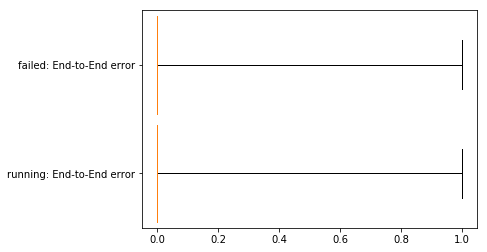

In [20]:
plot_feature('End-to-End error', st_df)

For the feature `End-to-End error`, we have the same boxplot for failed and for running devices. This value should be the count of parity errors. Its also interisting that this value is normalized from 0 upto 1. The representation as "error count" is not obvious at this point from a user perspective. From this representation I can't see an possible correlation with a failing drive. 

* Preferred: Low
* Correlation to Fail by Wikipedia: Yes

### Correlations found

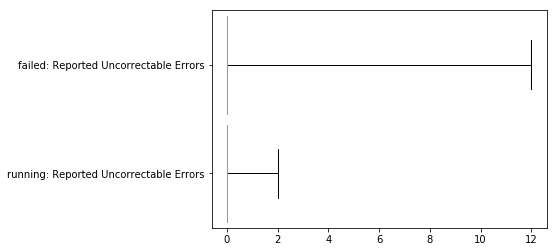

In [21]:
plot_feature('Reported Uncorrectable Errors', st_df)

One of the interisting features was `Reported Uncorrectable Errors` - this indeed looks very promising to be correlated to a hard drive fail, as the range of fail hard drives jumps upto 12 instead of being lower than 2.

* Referred: Low
* Correlation to Fail by Wikipedia: Yes
* **Correlation to Fail by given plot: Yes**

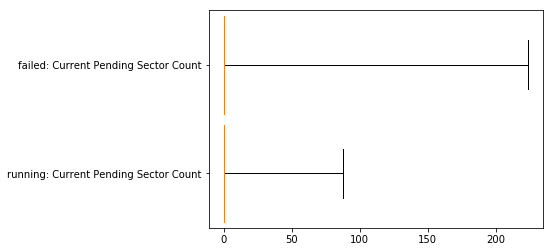

In [34]:
plot_feature('Current Pending Sector Count', st_df)

The feature `Current Pending Sector Count` seems to be a possible feature for predictions. Values above approx. 80 are only present for failing drives. This feature indicates the amount of "unstable" sectors on the hard drive.

* Preferred: Low
* Correlation to Fail by Wikipedia: Yes
* **Correlation to Fail by given plot: Yes**

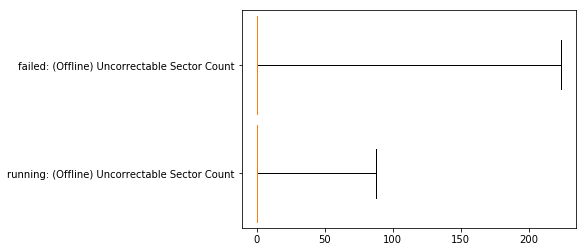

In [35]:
plot_feature('(Offline) Uncorrectable Sector Count', st_df)

This feature indicates the total count of uncorrectable errors while reading or writing. From the plot I assume a correlation between the fail of a hard drive and a value above approx. 80.

* Preferred: Low
* Correlation to Fail by Wikipedia: Yes
* **Correlation to Fail by given plot: Yes**

## Algorithms and Techniques

So fare we have worked with more balanced data and tried several algorithms against this datasets. But for heavy unbalanced data, I have no clue what algorithm to choose, so lets just try a lot of them and compare the results against each other based on their fbeta score! I searched some classfiers that I could found in scikit-learn and use them:


### SVC

A Support Vecotor Machine create a initial random function. This function is than used to calculate the distance of each point in the dataset. For each class in the dataset, the algorithm tries to maximaize the distance to this point. The function is slightly ajusted after each iteration and again compared with the previous results. As better the separation is possible, as better SVC works.

### Decision Trees

[reference](https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248)

Measuring the entroy to find a way to split the data and than reduce the amount of nodes to simlplity it and prevent an overfitting.

### LinearSVC

A Linear Support Vector Machine works the the genral svc, but only uses linear functions.

### SGDClassifier

generate a linear function. ask one point of the dataset, if the linear function line should move closer to the point or not. You can move the line by changing the parameters of the linear function. To measure the qualitiy we use a error function.

###  NearestCentroid
For each class calculate the mean of this data points. To generate a prediction, compare the distance to each center and return the shortest one.

### Naive Bayes
Caclulating that something is of kind "a" and calculating the probability that something is **not** of kind "a" - he higer value wins. The Naive approach is that the event of kind "a" is not related to any other event that is analysed.  Gaussian assumes that the total probability is distribibuted as a gaussian distribution.

### AdaBoost
AdaBoost used several instance of a algorithm, so called "weak learner". Each of this weak learners is doing a good job for a very small set of the data. This weak learners get each combined and boosted, according to their accuracy. The weak learners are often Decision Trees.

and boosts each result of this algorithm to even better fit the  data and improve the overall result.

### Random Forest
Instead of calculating one Decision Tree, Random Forest generates several Trees and all decide by themself. The majority of the outcomes by each Tree returns the final outcome by the tree.

### Multilayer Perceptron
A Perceptron is a adaption of a neuron inside human brains. A signal (data) goes in and a signal gets returned and transferred to another perceptron. The signal can be either reduced or increased, depending on the activision function of the perceptron. Perceptrons are organized in layers. Depending of the amount of layers, as more complex mathematical problems can be solved by the layers.

Each perceptron is initialized by a random value at the beginning. The first signal gets transferred over each layer. After finishing at the end, the weights of each connection gets updated (called backpropagation) to improve the accuracy of the network. Then the next signal passes and the process of backpropagation is repeated. The amount of repeating this process is one of the Hyperparameters of the Algorithm.

Most of this algorithms where run with their default settings. A different set of parameters could improve their results, but I wanted to have some all more or less good comparable based on their default settings.

I also tried a `Keras` neuronal network, `LightGBM` and `XGBoost` to even extend the amount of algorithms that are compared. For the last 3 algorithms I used a train, test and validation set. The validation set was used by the algorithm to improve. All tests sets where run after the model was generated to calculate the fbeta score.



## Benchmark
Googles(Eduardo Pinheiro et al.) results are as follows (link provided above, summary see wikipedia link):

* 60 days after finding uncorrectable errors (S.M.A.R.T. Value 198), the drive had 39 times higher change to fail
First errors in S.M.A.R.T. 196 (Relocation) and 5 (offline Relocation) are strongly correlated to higher probabilities of failure
* 56% of the drives failed without recording any count in the four string S.M.A.R.T. Warnings (Scan Errors, Relocation Count, offline Relocation and probiatinal Count)
* 36% Failed without any S.M.A.R.T. error at all

This lets me create the benchmark model as following:
The total amount of fails is 1.84% for all drives. 
This 1.84% can now be splitted into three groups, provided using the google paper:

Fails without errors: $1.84 \cdot 0.36 = 0.6624 %%$

Fails with any smart warning: $1.84 \cdot 0.56 = 1.0304 %$

Fails that could be predicted: $1.84 \cdot (1 - 0.36 - 0.56) = 0.8 %$ 

The Benchmark model, using random choice, predict with a change of 0.8% that a drive will fail. Each model have different chance to fail, this means that the 0.8 % is the average probability over every model in the dataset.

# Methodology
## Data Preprocessing


Now we prepare the current directories that we will use. 
* raw - contains the raw zip files, downloaded from backblaze
* drives - contains a csv file for each hard drive model
* train - contains the training set for each hard drive model as csv
* test - contains the test set for each hard drive model as csv
* validate - contains the validation set for each hard drive model as csv
* tmp - temp directory for splitting and normalization
* drives_minified - removed every non relevant data and feature from a given hard drive
* sklearn_models - containing models and results of sklearn algorithms
* keras_models - containing models and results for keras
* xgboost_models - containing models and results for xgboost
* lightgbm_models - containing models and results for lightgbm

When using the preprocessed data referenced in the README.md, some of this directories will already exist.

### Downloading and Unpacking and path fixing

In [9]:
preprocessing = Preprocessing()
preprocessing.download()

100%|██████████| 13/13 [00:00<00:00, 1625.51it/s]


In [29]:
preprocessing.unpack()

100%|██████████| 13/13 [00:00<00:00, 8670.05it/s]


In [31]:
preprocessing.rename() # To make sure each directory extracted have a normalized name

### Normalization
backblaze regularly add new S.M.A.R.T. values to their generated ouput. The new values are provided somewhere in "between" of existing values. The header of each files is:
* date - date the drive information was recorded
* serial numer of the drive
* the model
* the capacity
* the failure indicator
* then for each smart value the normalized and the raw value

The S.M.A.R.T. values are always in a increasing order upto 255. Adding new S.M.R.A.R.T columns, means adding them inbetween the existing ones. Reading the entire dataset is not possible, as the amount of memory required for this operation hits the 32 GB limit. Instead, the normalization have to be done directly on the files without reading everything at once.

I created two methods: `extract_smart_values` and `fill_content`.
`extract_smart_values` returns a map of an a colum to a appropriate smart value. Using this map, I can now add "blanks" to the dataset, to make sure that every file afterwords, have the same structure. I use `fill_content` for this approach. Both where moved to the [helper.py](helper.py) to reduce the amount of code inside this notebook a bit.

### Splitting by drive model
Some S.M.A.R.T. values are manufacture specific (see wikipedia article), you can't compare them between different manufacture. Sometimes the same value can have a different meaning and finally some models inside a manufacture can be add or removed comparing to different models. This forces us to split the entire dataset by hard drive type. As we have to go over several GB of csv data, this process takes over 1h on my device... 

In [ ]:
preprocessing.split_by_drive()

When everything went well, we can now move the files to the destination target

In [ ]:
preprocessing.split_by_drive_move()

unfortunately the data is now very huge and not all models could be read into ram after the splitting and calculating the models, so I had again to now transformn the data in a minified version, removing the before created empty spaces to reduce the file size - but now the data is consistent in each column.

Now triggering the minification, took 6h on my device.

In [16]:
total_files = glob.glob(os.path.join('drives','*.csv'))
with tqdm(total=len(total_files)) as pbar:
    for file in total_files:
        preprocessing.minify(file)
        pbar.update(1)
print('done')

100%|██████████| 107/107 [5:56:57<00:00, 200.16s/it]   


done


For a non failure, its ok to split the data randomly. But for failed drives, I really want to make sure to have an equal distribution over the entire dataset. Before we calculate the amount of failed drives for each model, and than split them according to the failure. 

If we have  a failed drive, we fist move the drives to the train dataset and reduce the total amount of drives we need for it. When the train set is "full", we add them to the test set and finally later add them to the validation set. this makes sure that we have a equal distribution of failed drives in every set. Otherwise, their can be a chance that we have no drive inside the train, test or validation group as we are dealing with a heavely unbalanced dataset.

In [10]:
if not os.path.exists('qualified.csv'):
    all_drives = glob.glob(os.path.join('drives_minified', '*.csv'))
    drive_metrics = Parallel(n_jobs=-1, backend="multiprocessing", verbose=1)(delayed(preprocessing.drive_metrics)(file) for file in all_drives)
    qualified_df = pd.DataFrame(drive_metrics)
    # Only include drives that have at least 3 failure records.
    qualified_df = qualified_df[qualified_df['failure'] >= 3]
    # Sort by lines, as small files are less compuation heavy and the long running tasks can run over night 
    #- but debugging can be done in faster iterations
    qualified_df.sort_values(by='lines', inplace=True)
    qualified_df.to_csv('qualified.csv', index=False)

As now the data is splitted, we have to make sure that the appropriate drives always include some fail drives, otherwise we can't do any training. Took after the minification only several minutes. Before the minification implemented, this took 20 minutes.

### Splitting by Train, Test and Validation Set

The following table now shows all our drives that we take a closer look at. As even more challenging, I also included drives that only have a small amount of fails. I assume as more failure are in general present, the more easy it is for an algorithm to generate a prediction for. We will take a look at it!

With the `final_split` function, we will now split the extracted models into a train, test and validation set according to the calculations we made before. As the extracted fail rate can be very slow, I use the previously calculated train, test and validation counts to make sure that they are present in the appropriate set and not get "randomly" moved to a different set.

In [21]:
# Run this sequencially, as I got corrupted data otherwise :-|
with tqdm(total=len(qualified_df)) as pbar:
    for _i, row in qualified_df.iterrows():
        preprocessing.final_split(row)
        pbar.update(1)

print('done')

100%|██████████| 60/60 [07:24<00:00,  7.41s/it]  


done


## Implementation

After finally doing sucessfully the preprocessing, we can now start to run the algorithms. For a more detail implementation, see [algorithm_runner.py](algorithm_runner.py).

### `FakeAlgorithm`
FakeAlgorithm is our benchmark algorithm that we need as a reference to compare against. 

In [2]:
class FakeAlgorithm:
    def fit(self, X, y):
        # Nothing to calculate
        return self
    
    def predict(self, X):
        """
        X - feature matrix to generate predictions for.
        returns a list with 0 and 1 for each row in the feature matrix.
        """
        y_pred = []
        for i in range(len(X)):
            y_pred.append(int(random.random() <= 0.08))
        return y_pred


### sklearn

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.naive_bayes import GaussianNB

### `DecisionTreeClassifier` [doc](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
`DecisionTreeClassifier` builds up a tree of decisions. Hyperparamers are `max_depth`, reflecting the level that the tree can get (default to no limit), `min_samples_leaf ` reflect the number of minimal samples that should be inside a node (defaults to 1)


###  `LinearSVC` [doc](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
`LinearSVC` "Similar to SVC with parameter kernel=’linear" -   hyperparameters: `tol` as the value for  the stopping criteria (defaults to 1e-4)and `max_iter ` the amount of iterations to run the algorithm.

### `SGDClassifier` [doc](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
`SGDClassifier` stochastic gradient descent. Hyperparameters: `tol` as the stop criterion. Set to 1-e3 as the new default value for sklearn 0.21. `max_iter` is the amount of iterations the algorithm should run.

### `NearestCentroid` [doc](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid)

"Each class is represented by its centroid, with test samples classified to the class with the nearest centroid." 

### `GaussianNB` [doc](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

"Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of independence between every pair of features." - I choosed the `GaussianNB` as it seems to be the most used one. No Hyperparameters are present.

### `AdaBoostClassifier` [doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)

The Hyperparameters are `base_estimator`, thats the base algorithm to use the number of instances reflected by `n_estimators` (default 50)  and the `learning_rate` (default 1.0)

### `RandomForestClassifier` [doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

"A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting." Compared to `AdaBoostClassifier`, no boosting is used. The Hyperparameters are `n_estimators` (default 10) and the number of levels to go deep with `max_depth`

### `MLPClassifier` [doc](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

`MLPClassifier` implements a Perceptron Classifier with 100 Hidden Layers described by `hidden_layer_sizes` 

In [5]:
clfs = [
    FakeAlgorithm(),
    DecisionTreeClassifier(),
    LinearSVC(),
    SGDClassifier(max_iter=1000, tol=1e-3), # defaults in sklearn 0.21
    NearestCentroid(),
    GaussianNB(),
    AdaBoostClassifier(n_estimators=100),
    RandomForestClassifier(n_estimators=100, n_jobs=-1),
    MLPClassifier()
]

Running all of the relevant sklearn algorithms:

In [5]:
qualified_df = pd.read_csv('qualified.csv')

clf_results = []

In [6]:
with tqdm(total=len(qualified_df)) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            pbar.set_description(drive_csv)
            
            # I don't use prepare_parallel, as the validation set is not needed and memory is everything...
            (X_train, y_train) =  AlgorithmRunner.prepare_train(drive_csv)
            (X_test, y_test) = AlgorithmRunner.prepare_test(drive_csv)
            
            # For the biggeest drive model, not run all algorithms in parallel to prevent out of memory errors.
            # Also only using some algorithms, as the runtime is just to huge even after runnning over night :-(
            if lines > 20000000:
                for clf in [FakeAlgorithm(), GaussianNB(), NearestCentroid()]:
                    result = AlgorithmRunner.run_parallel(clf, drive_csv, X_train, y_train, X_test, y_test)
                    clf_results.append(result)
            else: 
                # Run all algorithms in parallel with shared memory to have low memory overhead - its getting warm now :-D
                parallel_results = Parallel(n_jobs=-1, backend="threading")(delayed(AlgorithmRunner.run_parallel)(clf, drive_csv, X_train, y_train, X_test, y_test) for clf in clfs)
                for result in parallel_results:
                    clf_results.append(result)

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))
        pbar.update(1)

ST4000DM000.csv: 100%|██████████| 60/60 [04:19<00:00, 31.57s/it]            


### `SVC` [doc](http://scikit-learn.org/stable/modules/svm.html#svm-kernels)
`SVC` Support Vector Classifier tries to maximize the distance between (in our case 2) classes. This separation line is called hyperplane. At least `C` and the `kernel` should be mentioned here as hyperparameters. `C` that is the penalty parameter for the error term and the `kernel` to be choosen. `C` defaults to 1.0 and `kernel` to `rbf`. Running SVC only for all models as this seems to be the most computing intensive algorithm - running over the night. Please note that SVC works not that good for non normalized data, so the expected results should be not that good.


In [85]:
with tqdm(total=len(qualified_df)) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            pbar.set_description('SVC for {}'.format(drive_csv))
            # Again the calculation time is to high, skipping...
            if lines < 50000:
                (X_train, y_train) = prepare_train(drive_csv)
                (X_test, y_test) = prepare_test(drive_csv)
                result = AlgorithmRunner.run_parallel(SVC(), drive_csv, X_train, y_train, X_test, y_test)
                clf_results.append(result)

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))
        pbar.update(1)

SVC for ST4000DM000.csv: 100%|██████████| 60/60 [00:02<00:00, 28.11it/s]            


In [88]:
if not os.path.exists('results.csv'):
    results_df = pd.DataFrame(list(clf_results))
    results_df.to_csv('results.csv', index=False)

### Keras
Keras is a framwork implementing an abstract layer for several neuronal network / perceptron "backends" - I assumed that is should perform better than the `MLPClassifier` from sklearn. I used the tensorflow backend. For Keras I used a more explicit architecture: The amount of each layer is reduced by 10% of the total amount of features to have a smoth lowering of the amount of layers, stopping at 2 features to add a final Dense 1 layer with the sigmoid function. All other hidden layers use the relu function. For more Details, see [kerasalgorithm.py]([kerasalgorithm.py]). This algorithm is using a validation set to for a direct improvement / feedback.

In [15]:
from keras import backend as K

qualified_df = pd.read_csv('qualified.csv')
keras_results = []
with tqdm(total=len(qualified_df)) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            # Special case for keras: we need to pass the drive_csv name to create a valid checkpoint file path
            clf = KerasAlgorithm(drive_csv)
            pbar.set_description('{} for {}'.format(clf.__class__.__name__, drive_csv))
            (X_train, y_train, X_test, y_test, X_valid, y_valid) =  AlgorithmRunner.prepare_parallel(drive_csv)
            result =  AlgorithmRunner.run_parallel(clf, drive_csv, X_train, y_train, X_test, y_test, X_valid, y_valid)
            keras_results.append(result)
            K.clear_session()

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))

        pbar.update(1)

KerasAlgorithm for ST4000DM000.csv: 100%|██████████| 60/60 [03:37<00:00, 27.51s/it]            


In [90]:
if not os.path.exists('results_keras.csv'):
    results_df_keras = pd.DataFrame(keras_results)
    results_df_keras.to_csv('results_keras.csv', index=False)
results_df_keras = pd.read_csv('results_keras.csv')

### XGBoost
The XGBoost Framework implements a gradient boosting algorithm. I can be compared to [Adaboost](#AdaBoostClassifier-doc). To  be able to compare XGBoost with lightgbm, also a boosting algorithm, I set the `max_depth` Hyperparameter to 30, the learning rate `eta` to `0.01` and as `objective` used `binagry:logistic`. I also used a validation set for this Algorithm.  

In [6]:
qualified_df = pd.read_csv('qualified.csv')
xgboost_results = []
with tqdm(total=len(qualified_df)) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            clf = XGBoostGbtreeAlgorithm()
            pbar.set_description('{} for {}'.format(clf.__class__.__name__, drive_csv))

            (X_train, y_train, X_test, y_test, X_valid, y_valid) =  AlgorithmRunner.prepare_parallel(drive_csv)
            result =  AlgorithmRunner.run_parallel(clf, drive_csv, X_train, y_train, X_test, y_test, X_valid, y_valid)
            xgboost_results.append(result)

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))
        pbar.update(1)


XGBoostGbtreeAlgorithm for ST4000DM000.csv: 100%|██████████| 60/60 [03:40<00:00, 27.89s/it]            


In [93]:
if not os.path.exists('results_xgboost.csv'):
    results_df_xgboost = pd.DataFrame(xgboost_results)
    results_df_xgboost.to_csv('results_xgboost.csv', index=False)
results_df_xgboost = pd.read_csv('results_xgboost.csv')

### LightGBM [Code Idea](https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py)
Another Framework containing several boposting algorithms. I used the **G**radient **B**oosting **D**ecision **T**ree as boosting type. Again this is close to [Adaboost](#AdaBoostClassifier-doc). I choosed the same `learning_rate` as for XGboost of 0.01 with a `objective` of `binary`. The validation set was used.

In [2]:
qualified_df = pd.read_csv('qualified.csv')
total_items = len(qualified_df)
lightgbm_results = []
with tqdm(total=total_items) as pbar:
    for _i, row in qualified_df.iterrows():

        drive_csv = row['drive_csv']
        lines = row['lines']
        try:
            clf = LightGBMAlgorithm()
            pbar.set_description('{} for {}'.format(clf.__class__.__name__, drive_csv))

            (X_train, y_train, X_test, y_test, X_valid, y_valid) =  AlgorithmRunner.prepare_parallel(drive_csv)
            result =  AlgorithmRunner.run_parallel(clf, drive_csv, X_train, y_train, X_test, y_test, X_valid, y_valid)
            lightgbm_results.append(result)

        except Exception as err:
            print("error {} in: {}".format(drive_csv, err))
        pbar.update(1)

LightGBMAlgorithm for ST4000DM000.csv: 100%|██████████| 60/60 [03:44<00:00, 28.69s/it]            


In [96]:
if not os.path.exists('results_lightgbm.csv'):
    results_df_lightgbm = pd.DataFrame(lightgbm_results)
    results_df_lightgbm.to_csv('results_lightgbm.csv', index=False)
results_df_lightgbm = pd.read_csv('results_lightgbm.csv')

In [7]:
merged_result = Winner.calculate()

## Refinement
 
As different algorithms have won, I choose the drives where the `DecisionTreeClassifier` is the winner to further improve them:

In [2]:
merged_result = Winner.calculate()
all_drives = list(merged_result[merged_result['winner'] == 'DecisionTreeClassifier']['drive_csv'])

if not os.path.exists('grid_search.csv'):
    grid_search = []
    with tqdm(total=len(all_drives)) as pbar:
        for drive_csv in all_drives:
            pbar.set_description(drive_csv)
            grid_search.append(SearchWithGrid.run(drive_csv))
            pbar.update(1)
    SearchWithGrid.calculate_best(grid_search)  

WDC WD800AAJS.csv: 100%|██████████| 12/12 [24:40<00:00, 213.64s/it]


For the initial fbeta score, the default parameters where used:
* criterion="gini"
* splitter='best'
* max_depth=None
* min_samples_split=2

for the new fbeta score, max_depth of None also returned the best results. The new fbeta score was rounded.

|drive|fbetascore initial|fbetascore grid search|criterion|splitter|min_samples_split|
|---|---|
|ST4000DM005.csv|0.499613|0.499613|gini|best|2
|ST4000DM001.csv| 0.499845|0.499897|gini|best|2
|ST3160318AS.csv|0.499849|0.499849|gini|best|2
|WDC WD20EFRX.csv| 0.499889|0.49993|gini|random|2
|ST250LM004 HN.csv|0.499895|0.499895|gini|best|2
|ST9250315AS.csv|0.499911|0.499911|gini|best|4
|ST32000542AS.csv|0.499916|0.499916|gini|best|2
|ST3160316AS.csv|0.499922|0.499922|gini|best|2
|ST31500541AS.csv|0.528457|0.543369|entropy|best|3
|ST8000DM002.csv|0.566657|0.607134|gini|random|5
|WDC WD60EFRX.csv|0.611081|0.681788|gini|best|2
|WDC WD800AAJS.csv|1.0|1.0|gini|best|3

# Results
## Model Evaluation and Validation


In [6]:
merged_result = Winner.calculate()
np.mean(merged_result['FakeAlgorithm'])

0.4791606315695175

In [3]:
validation_results = Validation.run_all()

Taking a look a t the variance of the fbeta score over 6 runs of a kfold cross validation:

In [4]:
Validation.merge_and_show(validation_results)

,DecisionTreeClassifier,FakeAlgorithm,drive_csv,winner_f_beta,maximal_fbeta,mean_fbeta,minimal_fbeta
0,0.499613,0.476075,ST4000DM005.csv,0.499613,0.000000,0.000000,0.000000
1,0.499845,0.480548,ST4000DM001.csv,0.499845,0.049977,0.049977,0.049977
2,0.499849,0.479243,ST3160318AS.csv,0.499849,0.257868,0.249474,0.207874
3,0.499889,0.479679,WDC WD20EFRX.csv,0.499889,0.149917,0.116601,0.049986
4,0.499895,0.478194,ST250LM004 HN.csv,0.499895,0.149615,0.074843,0.049752
5,0.499911,0.480173,ST9250315AS.csv,0.499911,0.201165,0.183787,0.151217
6,0.499916,0.479727,ST32000542AS.csv,0.499916,0.382598,0.380919,0.377590
7,0.499922,0.482247,ST3160316AS.csv,0.499922,0.049990,0.049990,0.049990
8,0.528457,0.479389,ST31500541AS.csv,0.528457,0.474165,0.472167,0.470363
9,0.566657,0.479213,ST8000DM002.csv,0.566657,0.435894,0.429359,0.422831


Comparing to the random guess, that defined a fbeta score of $0.4792$ as mean, the kfold result of the grid searched `DecisionTreeClassifier` is more worse: $0.2032$. As requested by a review, I extended the kfold run to use different random states and recalculated them. The new mean is $0.202$ - in combination with the very low rate of failures, this low number seems legit. All folds with no predictions where classified as an fbeta score of $0.0$ 

## Justification

The calculated fbeta scores seems not to reflect the actual performance of the implemented classifiers. Lets take a more deep view of each range of fbeta score. Note that I am using here the initial calculated fbeta score for `DecisionTreeClassifier`.

### FBeta from 0.475 to 0.482

The provided results show that for a lot of drives, the untrained `FakeAlgorithm` generates a score between 0.47 and 0.482. Only for the `ST33000651AS` the `LinearSVC` performs slightly better than the `FakeAlgorithm`. 

### FBeta from 0.484 to 0.497

For this Range, the `GaussianNB` than performs better, again with an "outlier" by the `FakeAlgorithm`. It is possible that for the drive `ST2000DL003` the amount of data for this drive with 1238 is just not enough to let the algorithm, learn the patterns.

### FBeta  0.499 to 0.5

A lot of different algorithms win with this fbeta score.

|Algorithm|Wins|
|-----|---|
|AdaBoostClassifier|6|
|RandomForestClassifier|2|
|DecisionTreeClassifier|7|
|GaussianNB|1|
|SGDClassifier|1|
|LinearSVC|1|

This Range is the area of the somehow "Tree" based approaches, again with some outliers by `GaussianNB`, `SGDClassifier` and `LinearSVC`. All this drives outperform the random guess, they could detect some patterns inside the data, even with a low fbeta score.

### Fbeta from 0.5 to 0.52

The next range is leading by `GaussianNB` again. Only for the `Hitachi HDS722020ALA330` the `NearestCentroid` algorithm wins. `GaussianNB` have a Delta of only 0.000607 - so it was really close compared to the  `NearestCentroid` algorithm. A rerun of this dataset could already generate a different score and a different winner.

### FBeta from 0.52 to 0.55

This Range is totally mixed. Each winner is only one time present. We also have `Keras` and `XGBoost` first time as winners for a drive. 

### FBeta from 0.55 to 0.6

Going on in the next Range upto 0.6, we find the first time the `LightGBM` lib by Microsoft that I also used in this project to compare it. Its also interisting that this algorithm could finish without waiting for hours to complete, as `ST4000DM000` was the second biggest dataset. It also have the higest amount of failures in total. A lot of algorithms did not finish on my local environment with this drive. I not used cloud providers. 

### FBeta from 0.6 to 0.7

For to range upto 0.7, we first time find the "default" MLPClassifier. Suprisingly `Keras` did a really bad job on this drive. Its possible that my network that I created just not reflect the best Keras network at all...

### FBeta to 1

And finally the last range. We also have a fbeta Score of 1 for the drive `WDC WD800AAJS`. Note that this drive got a kfold fbeta score of a lower value.

# Conclusion
## Free-Form Visualization

In [2]:
freestyle = Freestyle()
freestyle.plot()

`AdaBoostClassifier` and `DecisionTreeClassifier` both share the first place in this competition. 

## Reflection


Steps that where done for this project:
* Download the data from backblaze
* Unpack is, restructure the unpacked data
* Extract each drive information to a separate file (splitting)
* remove unneded data and reduce memory requirement for reading (minify)
* create a train, test and validation set out of the separated files
* Run different binary classification algorithms on the drives and compare the results with each other.
* Do a Grid search for the winning algorithm. I did that for the `DecisionTreeClassifier`.
* Run KFold on the improved algorithm
* Group each drive by an fbeta score range and discuss the results

Regarding this project, they where a lot of trouble. First transferring the data from the mixed form into a standard form that every possible S.M.A.R.T. value is present. Then merging this different "raw" files together. Then splitting each model type out of mixes and splitting again for test, train and validation set. After doing a lot of the work, I got a lot more out of memory errors than now. I had to add the drive_minify method, to reduce the total amount of data I pass to the algorithm. Before this refactoring, I loaded the entire csv file into RAM and than dropped the unneded columns - but before I could drop them, the RAM was already full and I could not continue. Calculating the size of test train and validation set was also at some point wrong, as calculating $3 \cdot 0.1 = 0.3 -> 0 %$. But with no failures in test and validation set, the algorithms throw errors that a calculation is not possible. Having a very low amount of failures, I split the data in "bigger" parts to have more drives to run algorithms against.

I also struggeled with not running the algorithms in sequence, as the IO operations by pandas `read_csv` not even scratch the performance of the installed SSD (A Samsung SSD 850 EVO 1 TB) - I learned a lot!


## Improvement


Having more cpu power and RAM allows to calculate more algorithms and generate more results. Also a Gridsearch and a KFold can be implemented for more algorithms to check if it is really performing as good / poor as expeted. It is also interesting  to run them on even more frameworks like Apache Spark or pytorch to have a even bigger set of algorithms. Some cloud providers also offer their own implementation of different algorithms with hyperparameter tuning. This could also increase the number of algorithms that are comparing against each other.

In general, this challange is taff, as the overall failure rate is only 1.8% of all drives in average. It is like searching a needle in a haystack (german: "Nadel im Heuhaufen suchen"). This is also reflected by the general low fbeta score for a lot of drives.

I mixed drives with different capacity together. I could be interisting if splitting them by capacity somehow increases the accuracy. Also somebody could try to run the algorithms against all drives by a given manufacturer to have more failing drives in the datasets and compare them with my solution.

If you feel like giving me feedback, write me on Twitter @dariusmurawski